In [1]:
# -*- coding: utf-8 -*-

In [7]:
import re
import os
import sys
import pandas as pd
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import json
from scipy import stats
import csv
import pprint
from collections import defaultdict
import time
import datetime
import math
# import matplotlib.pyplot as plt; plt.rcdefaults()
# from IPython.display import Markdown, display

In [8]:
TIME_CHUNK_IN_DAYS = 10
QUARANTINE_DATE = "28/09/2018"
quarDataUnix = time.mktime(datetime.datetime.strptime(QUARANTINE_DATE, "%d/%m/%Y").timetuple())

TREATMENT_COMMENTS_FOLDER = "/mnt/storage/quarantine/data/"
TREATMENT_SUBMISSIONS_FOLDER = "/mnt/storage/quarantine/data/"

In [9]:
###load files and preprocess dataframes
def getTimeChunkIndex(timeStamp):
    timeStamp = float(timeStamp)
    timeDiff = timeStamp - quarDataUnix
    timeDiffDays = float(timeDiff)/(24*60*60) 
    chunkIndex = math.floor(timeDiffDays/TIME_CHUNK_IN_DAYS)
    return int(chunkIndex)

def load_data(subreddit, COMMENTS_FOLDER, SUBMISSIONS_FOLDER):
    comments_data = pd.read_csv(COMMENTS_FOLDER + subreddit + "-comments.csv")
    submissions_data = pd.read_csv(SUBMISSIONS_FOLDER + subreddit + "-submissions.csv")
    return comments_data, submissions_data

def preprocess_data(comments_data, submissions_data):
    ###preprocessing - retain only columns of importance
    comments_data = comments_data[['author', 'created_utc', 'body']]
    submissions_data = submissions_data[['author', 'created_utc', 'title', 'selftext']]
    
    ###make the column names the same
    submissions_data.rename(columns={'title': 'body'}, inplace=True)
    comments_data['selftext'] = 'EMPTY'
    comments_data['type'] = 'comment'
    submissions_data['type'] = 'submission'
    
    ###merge comments + submissions; remove rows with null author or created_utc
    subreddit_timeline = pd.concat([comments_data, submissions_data], ignore_index=True, sort=True)
    subreddit_timeline = subreddit_timeline.dropna(subset=['author', 'created_utc'])
    
    ###typecasting to prevent errors
    subreddit_timeline = subreddit_timeline[pd.to_numeric(subreddit_timeline['created_utc'], errors='coerce').notnull()]
    subreddit_timeline['author']=subreddit_timeline.author.astype('str')
    subreddit_timeline['body']=subreddit_timeline.body.astype('str')
    subreddit_timeline['selftext']=subreddit_timeline.selftext.astype('str')
    subreddit_timeline['created_utc']=subreddit_timeline.created_utc.astype('float')
    subreddit_timeline['type']=subreddit_timeline.type.astype('str')
    
    ###compute time variables for ITS
    subreddit_timeline['post_treatment'] = subreddit_timeline['created_utc'] > quarDataUnix
    subreddit_timeline['time'] = subreddit_timeline['created_utc'].apply(getTimeChunkIndex)
    
    return subreddit_timeline

def compute_posting_and_removal_volume(data):
    TrpRemovalCount = {}
    TotalNumberComments = {}
    authorsInEachChunk = defaultdict(set)
    for i, row in data.iterrows():
            body = row['body']
            selftext = row['selftext']
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)

            if timeChunkIndex in TotalNumberComments:
                TotalNumberComments[timeChunkIndex] += 1
            else:
                TotalNumberComments[timeChunkIndex] = 1

            ###count #removed
            if ((body == "[removed]") | (selftext == "[removed]")):
                if timeChunkIndex in TrpRemovalCount:
                    TrpRemovalCount[timeChunkIndex] += 1
                else:
                    TrpRemovalCount[timeChunkIndex] = 1
                    
            author = row['author']
            if (author != "[deleted]"):
                authorsInEachChunk[timeChunkIndex].add(author)                                                

    ##get the removal rate: i.e., #removed comments normalized by #total comments
    TrpRemovalRate = {}
    for k in TrpRemovalCount:
        if TotalNumberComments[k] == 0:
            TrpRemovalRate[k] = 0
        else:      
            TrpRemovalRate[k] = float(TrpRemovalCount[k])/(TotalNumberComments[k])            
            
    # Get influx of new users
    lists = sorted(authorsInEachChunk.items())
    seenUsersSet = set()
    for ulist in lists[0:3]:
        chunkUsers = ulist[1]
        seenUsersSet = seenUsersSet.union(chunkUsers)

    newUsersCount = defaultdict(int)
    for chunkIndex in TotalNumberComments.keys():
        newUsersCount[chunkIndex] = 1
    for ulist in lists[4:]:
        chunkIndex = ulist[0]
        chunkUsers = ulist[1]
        newUsersSet = chunkUsers.difference(seenUsersSet)
        newUsersCount[chunkIndex] += len(newUsersSet)
        seenUsersSet = seenUsersSet.union(chunkUsers)                

    return TotalNumberComments, TrpRemovalRate, newUsersCount
    
def get_effect(coeff):
    return np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

def its_posting_volume(TotalNumberComments, subreddit): 
    # posting volume
    TotalNumberComments_df = pd.DataFrame()
    TotalNumberComments_df['time'] = TotalNumberComments.keys()
    TotalNumberComments_df['counts'] = TotalNumberComments.values()
    TotalNumberComments_df['post_treatment'] = TotalNumberComments_df['time'] >= 0

    # ITS
    model = smf.poisson('counts ~ time + post_treatment', data = TotalNumberComments_df)
    results = model.fit()
    
    coeff = results.params[1]
    pval = results.pvalues[1]
    effect = get_effect(coeff)
    return coeff, pval, effect

def its_removal_rate(TrpRemovalRate, subreddit):
    TrpRemovalRate_df = pd.DataFrame()
    TrpRemovalRate_df['time'] = TrpRemovalRate.keys()
    TrpRemovalRate_df['counts'] = TrpRemovalRate.values()
    TrpRemovalRate_df['post_treatment'] = TrpRemovalRate_df['time'] >= 0

    # ITS
    model = smf.ols('counts ~ time + post_treatment', data = TrpRemovalRate_df)
    results = model.fit()
    
    coeff = results.params[1]
    pval = results.pvalues[1]
    effect = np.sign(coeff) * coeff * 100.0
    return coeff, pval, effect

def its_poisson(myDict, subreddit): 
    # posting volume
    df = pd.DataFrame()
    df['time'] = myDict.keys()
    df['counts'] = myDict.values()
    df['post_treatment'] = df['time'] >= 0

    # ITS
    model = smf.poisson('counts ~ time + post_treatment', data = df)
    results = model.fit()
    
    coeff = results.params[1]
    pval = results.pvalues[1]
    effect = get_effect(coeff)
    return coeff, pval, effect

In [10]:
treatment_subs_list = ['TheRedPill']

post_volume_subreddit_list = []
post_volume_coeff_list = []
post_volume_pval_list = []
post_volume_effect_list = []
removal_rate_subreddit_list = []
removal_rate_coeff_list = []
removal_rate_pval_list = []
removal_rate_effect_list = []
new_users_subreddit_list = []
new_users_coeff_list = []
new_users_pval_list = []
new_users_effect_list = []

count = 0

for subreddit in treatment_subs_list:
    print(count, subreddit)
    comments_data, submissions_data = load_data(subreddit, TREATMENT_COMMENTS_FOLDER, TREATMENT_SUBMISSIONS_FOLDER)
    subreddit_timeline = preprocess_data(comments_data, submissions_data)
    TotalNumberComments, TrpRemovalRate, newUsersCount = compute_posting_and_removal_volume(subreddit_timeline)
    
    coeff, pval, effect = its_posting_volume(TotalNumberComments, subreddit)
    post_volume_subreddit_list.append(subreddit)
    post_volume_coeff_list.append(coeff)
    post_volume_pval_list.append(pval)
    post_volume_effect_list.append(effect)
    
    coeff, pval, effect = its_removal_rate(TrpRemovalRate, subreddit)
    removal_rate_subreddit_list.append(subreddit)
    removal_rate_coeff_list.append(coeff)
    removal_rate_pval_list.append(pval)
    removal_rate_effect_list.append(effect)
    
    coeff, pval, effect = its_poisson(newUsersCount, subreddit)
    new_users_subreddit_list.append(subreddit)
    new_users_coeff_list.append(coeff)
    new_users_pval_list.append(pval)
    new_users_effect_list.append(effect)
    
    count += 1

0 TheRedPill


/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):
/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/nethome/eshwar3/anaconda3/lib/python3.7/site-packages/ipykern

Optimization terminated successfully.
         Current function value: 114.025854
         Iterations 5
Optimization terminated successfully.
         Current function value: 101.245995
         Iterations 5


# 1) ITS analysis for posting volume within r/TRP

Optimization terminated successfully.
         Current function value: 114.025854
         Iterations 5
                            Results: Poisson
Model:                  Poisson            Pseudo R-squared:   0.813    
Dependent Variable:     counts             AIC:                8215.8615
Date:                   2019-08-29 19:40   BIC:                8220.6121
No. Observations:       36                 Log-Likelihood:     -4104.9  
Df Model:               2                  LL-Null:            -21952.  
Df Residuals:           33                 LLR p-value:        0.0000   
Converged:              1.0000             Scale:              1.0000   
No. Iterations:         5.0000                                          
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               9.1128   0.0045 2040.606

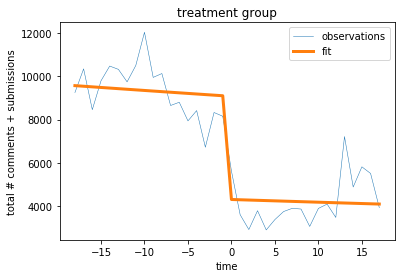

In [11]:
# ITS
TotalNumberComments_df = pd.DataFrame()
TotalNumberComments_df['time'] = TotalNumberComments.keys()
TotalNumberComments_df['counts'] = TotalNumberComments.values()
TotalNumberComments_df['post_treatment'] = TotalNumberComments_df['time'] >= 0

model = smf.poisson('counts ~ time + post_treatment',data = TotalNumberComments_df)
results = model.fit()

print(results.summary2())

# fitted values
TotalNumberComments_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TotalNumberComments_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('total # comments + submissions');

In [12]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -0.7417521809005514, 'Effect = ', -52.37213423939496)

**RESULT 1:** There was a **significant reduction of 52.37%** in posting volume (comments + submissions) within r/TRP that was caused by the quarantine.

# 2) ITS analysis for the influx of new users (i.e., rate of newcomers)

Optimization terminated successfully.
         Current function value: 101.245995
         Iterations 5
                           Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.386    
Dependent Variable:    counts             AIC:                7295.7116
Date:                  2019-08-29 19:40   BIC:                7300.4622
No. Observations:      36                 Log-Likelihood:     -3644.9  
Df Model:              2                  LL-Null:            -5933.0  
Df Residuals:          33                 LLR p-value:        0.0000   
Converged:             1.0000             Scale:              1.0000   
No. Iterations:        5.0000                                          
-----------------------------------------------------------------------
                        Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------
Intercept               6.8831   0.0153 450.5538 0.0000  6.8

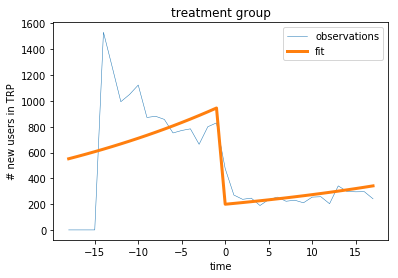

In [13]:
# # comments removed
TrpNewUsersCount_df = pd.DataFrame()
TrpNewUsersCount_df['time'] = newUsersCount.keys()
TrpNewUsersCount_df['counts'] = newUsersCount.values()
TrpNewUsersCount_df['post_treatment'] = TrpNewUsersCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpNewUsersCount_df)
results = model.fit()

print(results.summary2())
# fitted values
TrpNewUsersCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpNewUsersCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# new users in TRP');

In [14]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -1.58540932922838, 'Effect = ', -79.51360808380157)

**RESULT 2:** There was a **significant reduction (of 79.51%)** in newcomer rates within r/TRP that was caused by the quarantine.


# 3) ITS analysis for rate of comment removals within r/TRP

                   Results: Ordinary least squares
Model:               OLS               Adj. R-squared:      0.671     
Dependent Variable:  counts            AIC:                 -231.8089 
Date:                2019-08-29 19:40  BIC:                 -227.0584 
No. Observations:    36                Log-Likelihood:      118.90    
Df Model:            2                 F-statistic:         36.67     
Df Residuals:        33                Prob (F-statistic):  4.12e-09  
R-squared:           0.690             Scale:               8.6387e-05
----------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
----------------------------------------------------------------------
Intercept               0.1560   0.0036 43.5403 0.0000  0.1488  0.1633
post_treatment[T.True] -0.0253   0.0062 -4.0855 0.0003 -0.0380 -0.0127
time                   -0.0001   0.0003 -0.2192 0.8278 -0.0007  0.0005
--------------------------

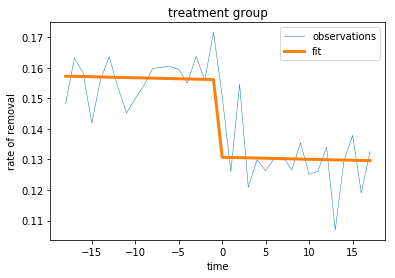

In [15]:
# # comments removed
TrpRemovalRate_df = pd.DataFrame()
TrpRemovalRate_df['time'] = TrpRemovalRate.keys()
TrpRemovalRate_df['counts'] = TrpRemovalRate.values()
TrpRemovalRate_df['post_treatment'] = TrpRemovalRate_df['time'] >= 0

# ITS
model = smf.ols('counts ~ time + post_treatment',data = TrpRemovalRate_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpRemovalRate_df['fit'] = (results.fittedvalues)
# TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpRemovalRate_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('rate of removal');

In [16]:
coeff = results.params[1]
"Coefficient = ", coeff,"Effect = ", np.ceil(100* coeff), "%"

('Coefficient = ', -0.025344383144142196, 'Effect = ', -2.0, '%')

**RESULT 3:** There was a **slight decrease of 2.0%** in the rate of removal within r/TRP that was caused by the quarantine (p-val = 0.0003).

# 4) ITS for Toxicity scores

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.000     
Dependent Variable:   TOXICITY         AIC:                85056.4748
Date:                 2019-08-29 19:41 BIC:                85087.3130
No. Observations:     215222           Log-Likelihood:     -42525.   
Df Model:             2                F-statistic:        10.51     
Df Residuals:         215219           Prob (F-statistic): 2.72e-05  
R-squared:            0.000            Scale:              0.086927  
---------------------------------------------------------------------
                       Coef.  Std.Err.    t     P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept              0.3426   0.0014 237.0239 0.0000  0.3398 0.3455
post_treatment[T.True] 0.0002   0.0027   0.0610 0.9513 -0.0052 0.0055
time                   0.0003   0.0001   2.2521 0.0243  0.0000 0.0005
---------------------------------------

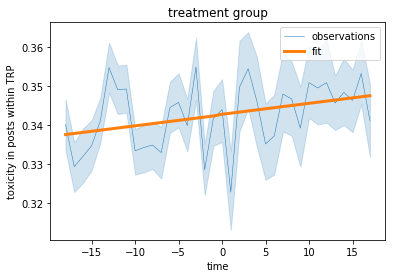

In [19]:
TOXICITY_COMMENTS_FILE = "/mnt/storage/quarantine/data/TheRedPill-comments-toxicity-scores.csv"
TOXICITY_SUBMISSIONS_FILE = "/mnt/storage/quarantine/data/TheRedPill-submissions-toxicity-scores.csv"
toxicity_comments_data = pd.read_csv(TOXICITY_COMMENTS_FILE)
toxicity_submissions_data = pd.read_csv(TOXICITY_SUBMISSIONS_FILE)

#filter out comments and posts that were removed or with toxicity score == -1.0 since they were not scored by API
toxicity_comments_data = toxicity_comments_data[toxicity_comments_data.TOXICITY >= 0]
toxicity_comments_data = toxicity_comments_data[toxicity_comments_data.body != "[removed]"]
toxicity_comments_data = toxicity_comments_data[['created_utc', 'TOXICITY']]
toxicity_submissions_data = toxicity_submissions_data[toxicity_submissions_data.TOXICITY >= 0]
toxicity_submissions_data = toxicity_submissions_data[toxicity_submissions_data.title != "[removed]"]
toxicity_submissions_data = toxicity_submissions_data[['created_utc', 'TOXICITY']]

toxicity_data = pd.concat([toxicity_comments_data, toxicity_submissions_data])

toxicity_data['post_treatment'] = toxicity_data['created_utc'] > quarDataUnix
toxicity_data['time'] = toxicity_data['created_utc'].apply(getTimeChunkIndex)

model = smf.ols('TOXICITY ~ time + post_treatment',data = toxicity_data)
results = model.fit()

print(results.summary2())

# fitted values
# data['fit'] = np.exp(results.fittedvalues)
toxicity_data['fit'] = results.fittedvalues

ax = sns.lineplot(data=toxicity_data,x='time',y='TOXICITY',linewidth=0.5)
ax = sns.lineplot(data=toxicity_data,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('toxicity in posts within TRP');

coeff = results.params[1]
print("Coefficient = ", coeff,"Effect = ", np.ceil(100* coeff), "%")

**RESULT 4:** There was **no significant change** in toxicity levels (of comments and posts) within r/TRP that was caused by the quarantine.

# Summary: Effects of Quarantining the r/TheRedPill

### 1) Posting volume: -52.37%; p-value = 0.0

### 2) Rate of newcomers: -79.51%; p-value = 0.0

### 3) Rate of post removals: -2.0%; p-value = 0.003

### 4) Toxicity levels of posts: 1.0% ; p-value = 0.9250

## 5) Measure changes in misogynistic language within TRP (using lexicon from prior work)

In [47]:
from getMisogynyLexicon import *
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

def get_misogyny_usage(data):
    TrpMisogynyCount = {}
    TotalWordCount = {}
    
    CATEGORY_NAMES, CATEGORY_WORDS = get_lexicon()
    misogyny_lexicon = list()

    for key in CATEGORY_WORDS:
        for word in CATEGORY_WORDS[key]:
            misogyny_lexicon.append(word)

    sage_lex = pd.DataFrame()
    sage_lex['word'] = misogyny_lexicon
    sage_lex = sage_lex.drop_duplicates()
    cv = CountVectorizer(vocabulary = sage_lex.word)

    ##tokenizer to get the number of words in the sentence
    tokenizer = RegexpTokenizer(r'\w+')
    
    for i, row in data.iterrows():
            body = row['body']
            selftext = row['selftext']
            postTime = row['created_utc']
            timeChunkIndex = getTimeChunkIndex(postTime)
            hate_iter = 0
            totalWords_iter = 0

            lis = []
            if row['type'] == "submission":
                lis.append(selftext)
            else:
                lis.append(body)

            arr = cv.fit_transform(lis).toarray()
            hate_iter += np.sum(arr)

            for text in lis:
                totalWords_iter += len(tokenizer.tokenize(text))

            if timeChunkIndex in TrpMisogynyCount:
                TrpMisogynyCount[timeChunkIndex] += hate_iter
            else:
                TrpMisogynyCount[timeChunkIndex] = hate_iter
                
            if timeChunkIndex in TotalWordCount:
                TotalWordCount[timeChunkIndex] += totalWords_iter
            else:
                TotalWordCount[timeChunkIndex] = totalWords_iter
                
    return TrpMisogynyCount, TotalWordCount

def its_lexicon(TrpMisogynyCount, subreddit): 
    # posting volume
    TrpMisogynyCount_df = pd.DataFrame()
    TrpMisogynyCount_df['time'] = TrpMisogynyCount.keys()
    TrpMisogynyCount_df['counts'] = TrpMisogynyCount.values()
    TrpMisogynyCount_df['post_treatment'] = TrpMisogynyCount_df['time'] >= 0

    # ITS
    model = smf.poisson('counts ~ time + post_treatment', data = TrpMisogynyCount_df)
    results = model.fit()
    
    coeff = results.params[1]
    pval = results.pvalues[1]
    effect = get_effect(coeff)
    return coeff, pval, effect

TrpMisogynyCount, TotalWordCount = get_misogyny_usage(subreddit_timeline)

Optimization terminated successfully.
         Current function value: 57.014599
         Iterations 5
                            Results: Poisson
Model:                  Poisson            Pseudo R-squared:   0.732    
Dependent Variable:     counts             AIC:                4111.0511
Date:                   2019-08-29 20:08   BIC:                4115.8017
No. Observations:       36                 Log-Likelihood:     -2052.5  
Df Model:               2                  LL-Null:            -7656.0  
Df Residuals:           33                 LLR p-value:        0.0000   
Converged:              1.0000             Scale:              1.0000   
No. Iterations:         5.0000                                          
------------------------------------------------------------------------
                        Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Intercept               8.0755   0.0073 1100.1858

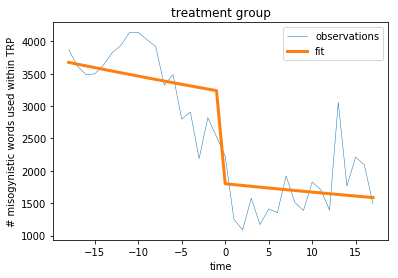

In [54]:
# count = 0
# for subreddit in treatment_subs_list:
#     print(count, subreddit)
#     comments_data, submissions_data = load_data(subreddit, TREATMENT_COMMENTS_FOLDER, TREATMENT_SUBMISSIONS_FOLDER)
#     subreddit_timeline = preprocess_data(comments_data, submissions_data)
#     TrpMisogynyCount, TotalWordCount = get_misogyny_usage(subreddit_timeline.sample(n=10000))
    
#     coeff, pval, effect = its_posting_volume(TrpMisogynyCount, subreddit)
#     print(coeff, pval, effect)
#     count += 1

# TrpMisogynyCount, TotalWordCount = get_misogyny_usage(subreddit_timeline)

TrpMisogynyCount_df = pd.DataFrame()
TrpMisogynyCount_df['time'] = TrpMisogynyCount.keys()
TrpMisogynyCount_df['counts'] = TrpMisogynyCount.values()
TrpMisogynyCount_df['post_treatment'] = TrpMisogynyCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TrpMisogynyCount_df)
results = model.fit()

print(results.summary2())
# fitted values
TrpMisogynyCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpMisogynyCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpMisogynyCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# misogynistic words used within TRP');

In [55]:
coeff = results.params[1]
"Coeff = ", coeff, "Effect = ", np.sign(coeff) * (100* (1.0 - np.exp(coeff)))

('Coeff = ', -0.5794889846844476, 'Effect = ', -43.98154436766835)

Optimization terminated successfully.
         Current function value: 5053.265606
         Iterations 5
                            Results: Poisson
Model:                 Poisson            Pseudo R-squared:   0.809      
Dependent Variable:    counts             AIC:                363841.1236
Date:                  2019-08-29 20:16   BIC:                363845.8742
No. Observations:      36                 Log-Likelihood:     -1.8192e+05
Df Model:              2                  LL-Null:            -9.5073e+05
Df Residuals:          33                 LLR p-value:        0.0000     
Converged:             1.0000             Scale:              1.0000     
No. Iterations:        5.0000                                            
-------------------------------------------------------------------------
                        Coef.  Std.Err.     z      P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept              13.0962   0.0

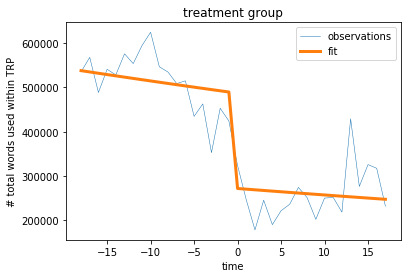

In [56]:
TotalWordCount_df = pd.DataFrame()
TotalWordCount_df['time'] = TotalWordCount.keys()
TotalWordCount_df['counts'] = TotalWordCount.values()
TotalWordCount_df['post_treatment'] = TotalWordCount_df['time'] >= 0

# ITS
model = smf.poisson('counts ~ time + post_treatment',data = TotalWordCount_df)
results = model.fit()

print(results.summary2())
# fitted values
TotalWordCount_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TotalWordCount_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TotalWordCount_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
ax.set_ylabel('# total words used within TRP');

                   Results: Ordinary least squares
Model:                OLS              Adj. R-squared:     0.003     
Dependent Variable:   counts           AIC:                -443.5942 
Date:                 2019-08-30 13:48 BIC:                -438.8436 
No. Observations:     36               Log-Likelihood:     224.80    
Df Model:             2                F-statistic:        1.045     
Df Residuals:         33               Prob (F-statistic): 0.363     
R-squared:            0.060            Scale:              2.4073e-07
---------------------------------------------------------------------
                        Coef.  Std.Err.    t    P>|t|   [0.025 0.975]
---------------------------------------------------------------------
Intercept               0.0067   0.0002 35.3009 0.0000  0.0063 0.0071
post_treatment[T.True] -0.0002   0.0003 -0.6258 0.5357 -0.0009 0.0005
time                   -0.0000   0.0000 -0.1087 0.9141 -0.0000 0.0000
---------------------------------------

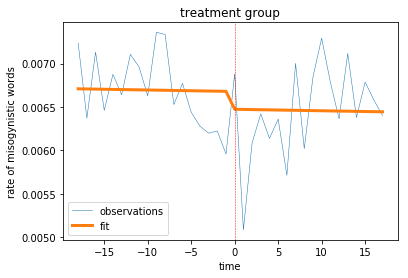

In [79]:
##get the frequency rate of misogynistic words: i.e., #misogynistic words normalized by #total words
TrpMisogynyRate = {}
for k in TrpMisogynyCount:
    if TotalWordCount[k] == 0:
        TrpMisogynyRate[k] = 0
    else:      
        TrpMisogynyRate[k] = float(TrpMisogynyCount[k])/(TotalWordCount[k])            

TrpMisogynyRate_df = pd.DataFrame()
TrpMisogynyRate_df['time'] = TrpMisogynyRate.keys()
TrpMisogynyRate_df['counts'] = TrpMisogynyRate.values()
TrpMisogynyRate_df['post_treatment'] = TrpMisogynyRate_df['time'] >= 0

# ITS
model = smf.ols('counts ~ time + post_treatment',data = TrpMisogynyRate_df)
results = model.fit()

print(results.summary2())

# fitted values
TrpMisogynyRate_df['fit'] = (results.fittedvalues)
# TrpRemovalRate_df['fit'] = np.exp(results.fittedvalues)
ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='counts',linewidth=0.5)
ax = sns.lineplot(data=TrpMisogynyRate_df,x='time',y='fit', ax = ax, linewidth=3)
ax.set_title('treatment group')
plt.legend(['observations','fit'])
# plt.axvline(0)
plt.axvline(x=0, linewidth=0.5, linestyle = '--', color='r')
ax.set_ylabel('rate of misogynistic words');

In [53]:
coeff = results.params[1]
"Coefficient = ", coeff,"Effect = ", np.ceil(100* coeff), "%"

('Coefficient = ', -0.0002049343913065637, 'Effect = ', -0.0, '%')